In [1]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.utils import load_img, img_to_array
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

In [2]:
!echo "Downloading Catsanddogs for image notebooks"
!pip install unzip
!curl -L -o Catsanddogs.zip --progress-bar https://github.com/glaucomori/Educational/raw/main/DIO.me/Ci%C3%AAncia%20de%20Dados%20-%20Gera%C3%A7%C3%A3o%20Tech%20Unimed%20BH/005%20-%20Machine%20Learning/Final%20Challenge%20-%20Transfer%20Learning/Catsanddogs.zip
!unzip -o Catsanddogs.zip
!tar -xzf /content/Catsanddogs/PetImages.tar.gz
!sudo rm -rf Catsanddogs.zip /content/Catsanddogs
!ls

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for unzip: filename=unzip-1.0.0-py3-none-any.whl size=1319 sha256=d6ad37a89da2b3334a29b82ce2550a4e362654c75035df3989e7097d8d81dc2e
  Stored in directory: /root/.cache/pip/wheels/c5/05/b3/f7b36dbaaf76de31b718cde792c953bfd11d2414a72f204b56
Successfully built unzip
######################################################################## 100.0%
Archive:  Catsanddogs.zip
   creating: Catsanddogs/
 extracting: Catsanddogs/PetImages.tar.gz  
PetImages  sample_data


In [3]:
root = 'PetImages'
exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces']
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

print(categories)

['PetImages/Cat', 'PetImages/Dog']


In [4]:
# helper function to load image and return it and input vector
def get_image(path):
    img = load_img(path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [5]:
data = []
for c, category in enumerate(categories):
    try:
        images = [os.path.join(dp, f) for dp, dn, filenames 
                in os.walk(category) for f in filenames 
                if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
        for img_path in images:
            img, x = get_image(img_path)
            data.append({'x':np.array(x[0]), 'y':c})
    except:
        continue

# count the number of classes
num_classes = len(categories)

In [6]:
random.shuffle(data)

In [7]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

In [8]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0]


In [9]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(31, 2)


In [10]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 202 images from 2 categories
train / validation / test split: 141, 30, 31
training data shape:  (141, 224, 224, 3)
training labels shape:  (141, 2)


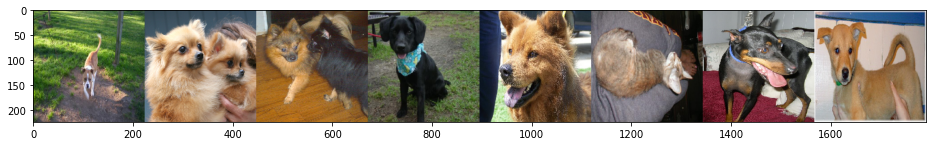

In [11]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

In [12]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                   

In [13]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
2/2 [==============================] - 20s 3s/step - loss: 0.7011 - accuracy: 0.5248 - val_loss: 0.6906 - val_accuracy: 0.4667
Epoch 2/10
2/2 [==============================] - 14s 1s/step - loss: 0.6840 - accuracy: 0.5603 - val_loss: 0.6901 - val_accuracy: 0.5667
Epoch 3/10
2/2 [==============================] - 9s 2s/step - loss: 0.6935 - accuracy: 0.5461 - val_loss: 0.7084 - val_accuracy: 0.5333
Epoch 4/10
2/2 [==============================] - 10s 1s/step - loss: 0.7044 - accuracy: 0.4610 - val_loss: 0.6966 - val_accuracy: 0.5333
Epoch 5/10
2/2 [==============================] - 9s 1s/step - loss: 0.7014 - accuracy: 0.4752 - val_loss: 0.6946 - val_accuracy: 0.4667
Epoch 6/10
2/2 [==============================] - 9s 1s/step - loss: 0.6693 - accuracy: 0.6241 - val_loss: 0.6957 - val_accuracy: 0.4667
Epoch 7/10
2/2 [==============================] - 9s 1s/step - loss: 0.6819 - accuracy: 0.5248 - val_loss: 0.6962 - val_accuracy: 0.4667
Epoch 8/10
2/2 [======================

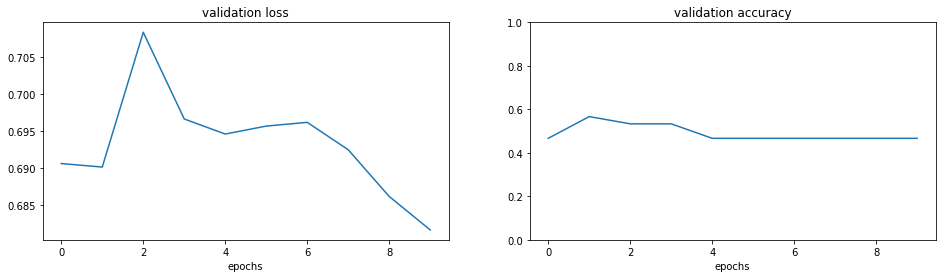

In [14]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [15]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.728448212146759
Test accuracy: 0.35483869910240173


In [16]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [17]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


In [18]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [19]:
history2 = model_new.fit(x_train, y_train, 
                         batch_size=128, 
                         epochs=10, 
                         validation_data=(x_val, y_val))

Epoch 1/10
2/2 [==============================] - 108s 22s/step - loss: 0.7479 - accuracy: 0.5177 - val_loss: 0.5926 - val_accuracy: 0.7333
Epoch 2/10
2/2 [==============================] - 90s 22s/step - loss: 0.6664 - accuracy: 0.6667 - val_loss: 1.1518 - val_accuracy: 0.4667
Epoch 3/10
2/2 [==============================] - 91s 24s/step - loss: 0.9963 - accuracy: 0.5390 - val_loss: 0.5554 - val_accuracy: 0.7000
Epoch 4/10
2/2 [==============================] - 92s 23s/step - loss: 0.6507 - accuracy: 0.6454 - val_loss: 0.7859 - val_accuracy: 0.5333
Epoch 5/10
2/2 [==============================] - 92s 24s/step - loss: 0.9077 - accuracy: 0.4752 - val_loss: 0.4969 - val_accuracy: 0.7667
Epoch 6/10
2/2 [==============================] - 91s 23s/step - loss: 0.5491 - accuracy: 0.7376 - val_loss: 0.6480 - val_accuracy: 0.4667
Epoch 7/10
2/2 [==============================] - 93s 24s/step - loss: 0.6436 - accuracy: 0.5532 - val_loss: 0.5687 - val_accuracy: 0.5667
Epoch 8/10
2/2 [==========

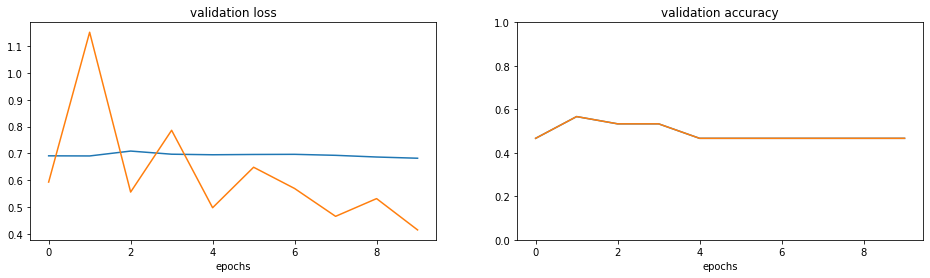

In [21]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [22]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.501349687576294
Test accuracy: 0.774193525314331


In [23]:
img, x = get_image('PetImages/Dog/87.jpg')
probabilities = model_new.predict([x])

1/1 [==============================] - 1s 781ms/step
